---
# **データサイエンス基礎　第8回課題**
## **【重回帰分析】複数の気象データから電力需要を推定する重回帰モデルの作成**
---
### 1. データの概要
　今回扱うデータは，前回と同様，[気象庁の過去の気象データ](https://www.data.jma.go.jp/gmd/risk/obsdl/index.php)より得られる埼玉県熊谷市の気象データと，[東京電力パワーグリッド株式会社が公表する過去の電力使用実績データ](https://www.tepco.co.jp/forecast/)より得られる東京エリアの電力使用実績データを，それぞれのSheetに記述し，1つのExcelファイルとしてまとめたものである．
> [https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx](https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx)  
  
　このExcel形式のデータを処理して，最高気温と電力需要の単回帰分析および多項式回帰分析を行う．
### 2. $YYYY$ 年 $MM$ 月の気象データより電力需要を推定する重回帰モデルの作成
　プログラムの汎用化のために，特定の年度，月における気象データおよび電力需要の範囲内で重回帰モデルを決定可能となるように工夫する．年度や月を考えない場合は，Falseとする．  
#### (1) データの読み込み
　まず，各シートの1行目に関して，今回タイトルとして扱いたい情報が含まれない．したがって，1行目を無視する必要がある．また，2，3行目もタイトル行として扱うには不備があり，扱いにくい．以上より，1，2，3行目を無視し，データフレームのタイトル行は自分で定義する必要があると考えられる．  
　また，気象データのうち，独立変数として用いられる可能性があるのは，”平均気温”，”最高気温”，”最低気温”，”降水量”，”日照時間”，”降雪量”，”平均風速”，”平均蒸気圧”，”平均湿度”，”平均現地気圧”の10個である．  
　さらに，電力需要のデータは，1日の1時間毎にデータが記録されている．したがって，この平均値をとり，その日の電力需要とする必要がある．  
　重回帰モデルの作成・出力には，Pythonライブラリであるstatsmodelsを利用する．

In [1]:
# ライブラリの読み込み
# %pip install --upgrade pip
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install openpyxl
# %pip install sympy
# %pip install scipy
# %pip install re
# %pip install jaconv
# %pip install scikit-learn
# %pip install statsmodels
# %pip install seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import sympy as sp
import scipy.stats as stats
import re
import jaconv 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import itertools


# 変数の定義
year = False                # 対象年度      ：指定しない場合はFalse
month = False               # 対象月        ：指定しない場合はFalse

# 対象気象データ名（従属変数候補名）
X_name = ['平均気温', '最高気温', '最低気温', '降水量', '日照時間', 
        '降雪量', '平均風速', '平均蒸気圧', '平均湿度', '平均現地気圧']     


# 気象データのExcel Sheetの読み込み
df_weather = pd.read_excel( 'ds07_temp_power_exercise.xlsx', 
                        sheet_name='2020熊谷市気象データ_data', skiprows=[0,1,2],
                        names= ['年月日', '平均気温', '', '', '最高気温', '', '', '', '', '最低気温', '', '', '', '', 
                                '降水量', '', '', '', '日照時間', '', '', '', '降雪量', '', '', '', '平均風速', '', '', 
                                '平均蒸気圧', '', '', '平均湿度', '', '', '平均現地気圧', '', '', '', '', '', '天気概況', '', ''])
df_weather['年月日'] = pd.to_datetime(df_weather['年月日'], format='%Y/%m/%d')

# 電力需要データのExcel Sheetの読み込み
df_power = pd.read_excel('ds07_temp_power_exercise.xlsx', 
                        sheet_name='東京電力パワーグリッド エリア需給実績データ', skiprows=[0,1],
                        names=['年月日', '時間', '電力需要', '', '', '', '', '', '', '', '', '', '', '', ''])
df_power['年月日'] = pd.to_datetime(df_power['年月日'], format='%Y/%m/%d')


# 対象データの抽出（X：独立変数，Y：従属変数）
def dataLoading(year, month, X_name):
    if (year == False) and (month != False) :
        X = df_weather[df_weather['年月日'].dt.month == month][X_name]
        Y = df_power[df_power['年月日'].dt.month == month]\
                    .groupby(df_power['年月日'])['電力需要'].mean().reset_index()

    elif (year != False) and (month == False):
        X = df_weather[df_weather['年月日'].dt.year == year][X_name]
        Y = df_power[df_power['年月日'].dt.year == year]\
                    .groupby(df_power['年月日'])['電力需要'].mean().reset_index()

    elif (year == False) and (month == False):
        X = df_weather[X_name]
        Y = df_power\
                    .groupby(df_power['年月日'])['電力需要'].mean().reset_index()

    else :
        X = df_weather[(df_weather['年月日'].dt.year == year) & (df_weather['年月日'].dt.month == month)][X_name]
        Y = df_power[(df_power['年月日'].dt.year == year) & (df_power['年月日'].dt.month == month)]\
                    .groupby(df_power['年月日'])['電力需要'].mean().reset_index()

    return (X, Y['電力需要'])

X_weather, Y_power = dataLoading(year, month, X_name)

#### (2) 独立変数の選定 
　今回は，情報量規準であるAIC（赤池情報量基準）やBIC（ベイズ情報量基準）の値が最も優れた（それぞれを小さい順に並べたときの順位の合計の最小値となる）場合のモデルを探索するようにプログラムする．その後，VIF（分散拡大要因）の値も比較的小さくなっていることを確認し，最適なモデルを決定する．  
> 参考：https://research.miidas.jp/2019/04/aic%e3%81%a8bic%ef%bc%9f%e6%83%85%e5%a0%b1%e9%87%8f%e5%9f%ba%e6%ba%96%e3%81%a8%e3%81%af%ef%bc%9f/  
> 　　：https://best-biostatistics.com/correlation_regression/multi-co.html 
  

In [2]:
# 重回帰分析を実施
def multipleRegression(X, Y, SUMMARY, VIF):
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    num_cols = model.exog.shape[1]
    result = model.fit()
    if SUMMARY == True:
        print(result.summary(xname=model.exog_names))
        summaries = result.summary(xname=model.exog_names)
        for table in summaries.tables:
            print(table)
    if VIF == True:
        vifs = [vif(model.exog, i) for i in range(0, num_cols)]
        display(pd.DataFrame(vifs, index=model.exog_names, columns=['VIF']))
    return (result.aic, result.bic)

# 全ての独立変数を用いた場合の重回帰分析を実施
print('##########################################################################################')
print('##########################################################################################')
print('###                                                                                    ###')
print('###   Condition :               All Independent Variables                              ###')
print('###                                                                                    ###')
print('##########################################################################################')
print('##########################################################################################')
multipleRegression(X=X_weather, Y=Y_power, SUMMARY=True, VIF=True)
print('##########################################################################################')
print('##########################################################################################\n')


combinations = []                                   # 独立変数の組み合わせを格納するリスト
df_IC = pd.DataFrame(columns=['sum', 'combo'])      # AICとBICのデータを格納するデータフレーム
df_AIC = pd.DataFrame(columns=['AIC', 'combo'])     # AICのデータを格納するデータフレーム
df_BIC = pd.DataFrame(columns=['BIC', 'combo'])     # BICのデータを格納するデータフレーム

# 独立変数の全ての組み合わせを用意
for r in range(1, len(X_name) + 1):
    combo = list(itertools.combinations(X_name, r))
    combinations.extend(combo)

# 瀬部手の組み合わせに対して重回帰を行い，AICとBICを取得
for combo in combinations:
    combo = list(combo)
    X, Y = dataLoading(year, month, combo)
    aic, bic = multipleRegression(X=X, Y=Y, SUMMARY=False, VIF=False)
    new_row = pd.DataFrame({'AIC': [aic], 'combo': [combo]})
    if not new_row.isnull().all().all():
        df_AIC = pd.concat([df_AIC, new_row], ignore_index=True)
    new_row = pd.DataFrame({'BIC': [bic], 'combo': [combo]})
    df_BIC = pd.concat([df_BIC, new_row], ignore_index=True)
df_AIC['rank'] = df_AIC['AIC'].rank(method='min')
df_BIC['rank'] = df_BIC['BIC'].rank(method='min')
df_AIC.to_csv('AIC.csv')
df_BIC.to_csv('BIC.csv')

# 最適な（AICとBICが小さくなるような）独立変数の組み合わせを探索
for i in range(0, len(combinations)):
    rank_sum = df_AIC.iloc[i]['rank'] + df_BIC.iloc[i]['rank']
    new_row = pd.DataFrame({'sum': [rank_sum], 'combo': [df_AIC.iloc[i]['combo']]})
    df_IC = pd.concat([df_IC, new_row], ignore_index=True)
df_IC = df_IC.sort_values(by='sum')
df_IC.to_csv('models_rank.csv')

# 最適な重回帰モデルの候補を出力
for i in range(1):
    X_optimal, Y_optimal = dataLoading(year, month, df_IC.iloc[i]['combo'])
    print('##########################################################################################')
    print('##########################################################################################')
    print('###                                                                                    ###')
    print(f'###   Condition :             Optimal Independent Variables ({i+1})                        ###')
    print('###                                                                                    ###')
    print('##########################################################################################')
    print('##########################################################################################')
    multipleRegression(X=X_optimal, Y=Y_optimal, SUMMARY=True, VIF=True)
    print('##########################################################################################')
    print('##########################################################################################\n')

##########################################################################################
##########################################################################################
###                                                                                    ###
###   Condition :               All Independent Variables                              ###
###                                                                                    ###
##########################################################################################
##########################################################################################
                            OLS Regression Results                            
Dep. Variable:                   電力需要   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     41.78
Date:                Sun, 09 Jun 2024   Prob (F

,VIF
const,37805.631637
平均気温,261.172612
最高気温,81.167846
最低気温,108.006856
降水量,1.393448
日照時間,4.891613
降雪量,1.091461
平均風速,2.708077
平均蒸気圧,23.940788
平均湿度,7.289011


##########################################################################################
##########################################################################################

##########################################################################################
##########################################################################################
###                                                                                    ###
###   Condition :             Optimal Independent Variables (1)                        ###
###                                                                                    ###
##########################################################################################
##########################################################################################
                            OLS Regression Results                            
Dep. Variable:                   電力需要   R-squared:                       0.536
Model:                

,VIF
const,171.160903
平均気温,15.930759
日照時間,2.841618
降雪量,1.057532
平均風速,1.640780
平均蒸気圧,21.956918
平均湿度,6.264165


##########################################################################################
##########################################################################################



　したがって，AICとBICが小さくなるようなモデルを探索した結果，”平均気温，日照時間，降雪量，平均風速，，平均蒸気圧，平均湿度” という組み合わせが最適であるという結果を得た．しかし，VIFの値を見ると，10を超えている独立変数も含まれ，このモデルを最適として良いのか危ぶまれる．  
#### (3) 独立変数同士あるいは従属変数との相関関係の可視化
　ペアプロットやヒートマップを用いて，独立変数同士あるいは従属変数との相関関係を可視化する．   
　その後，探索結果と変数の相関関係を比較して考察する．

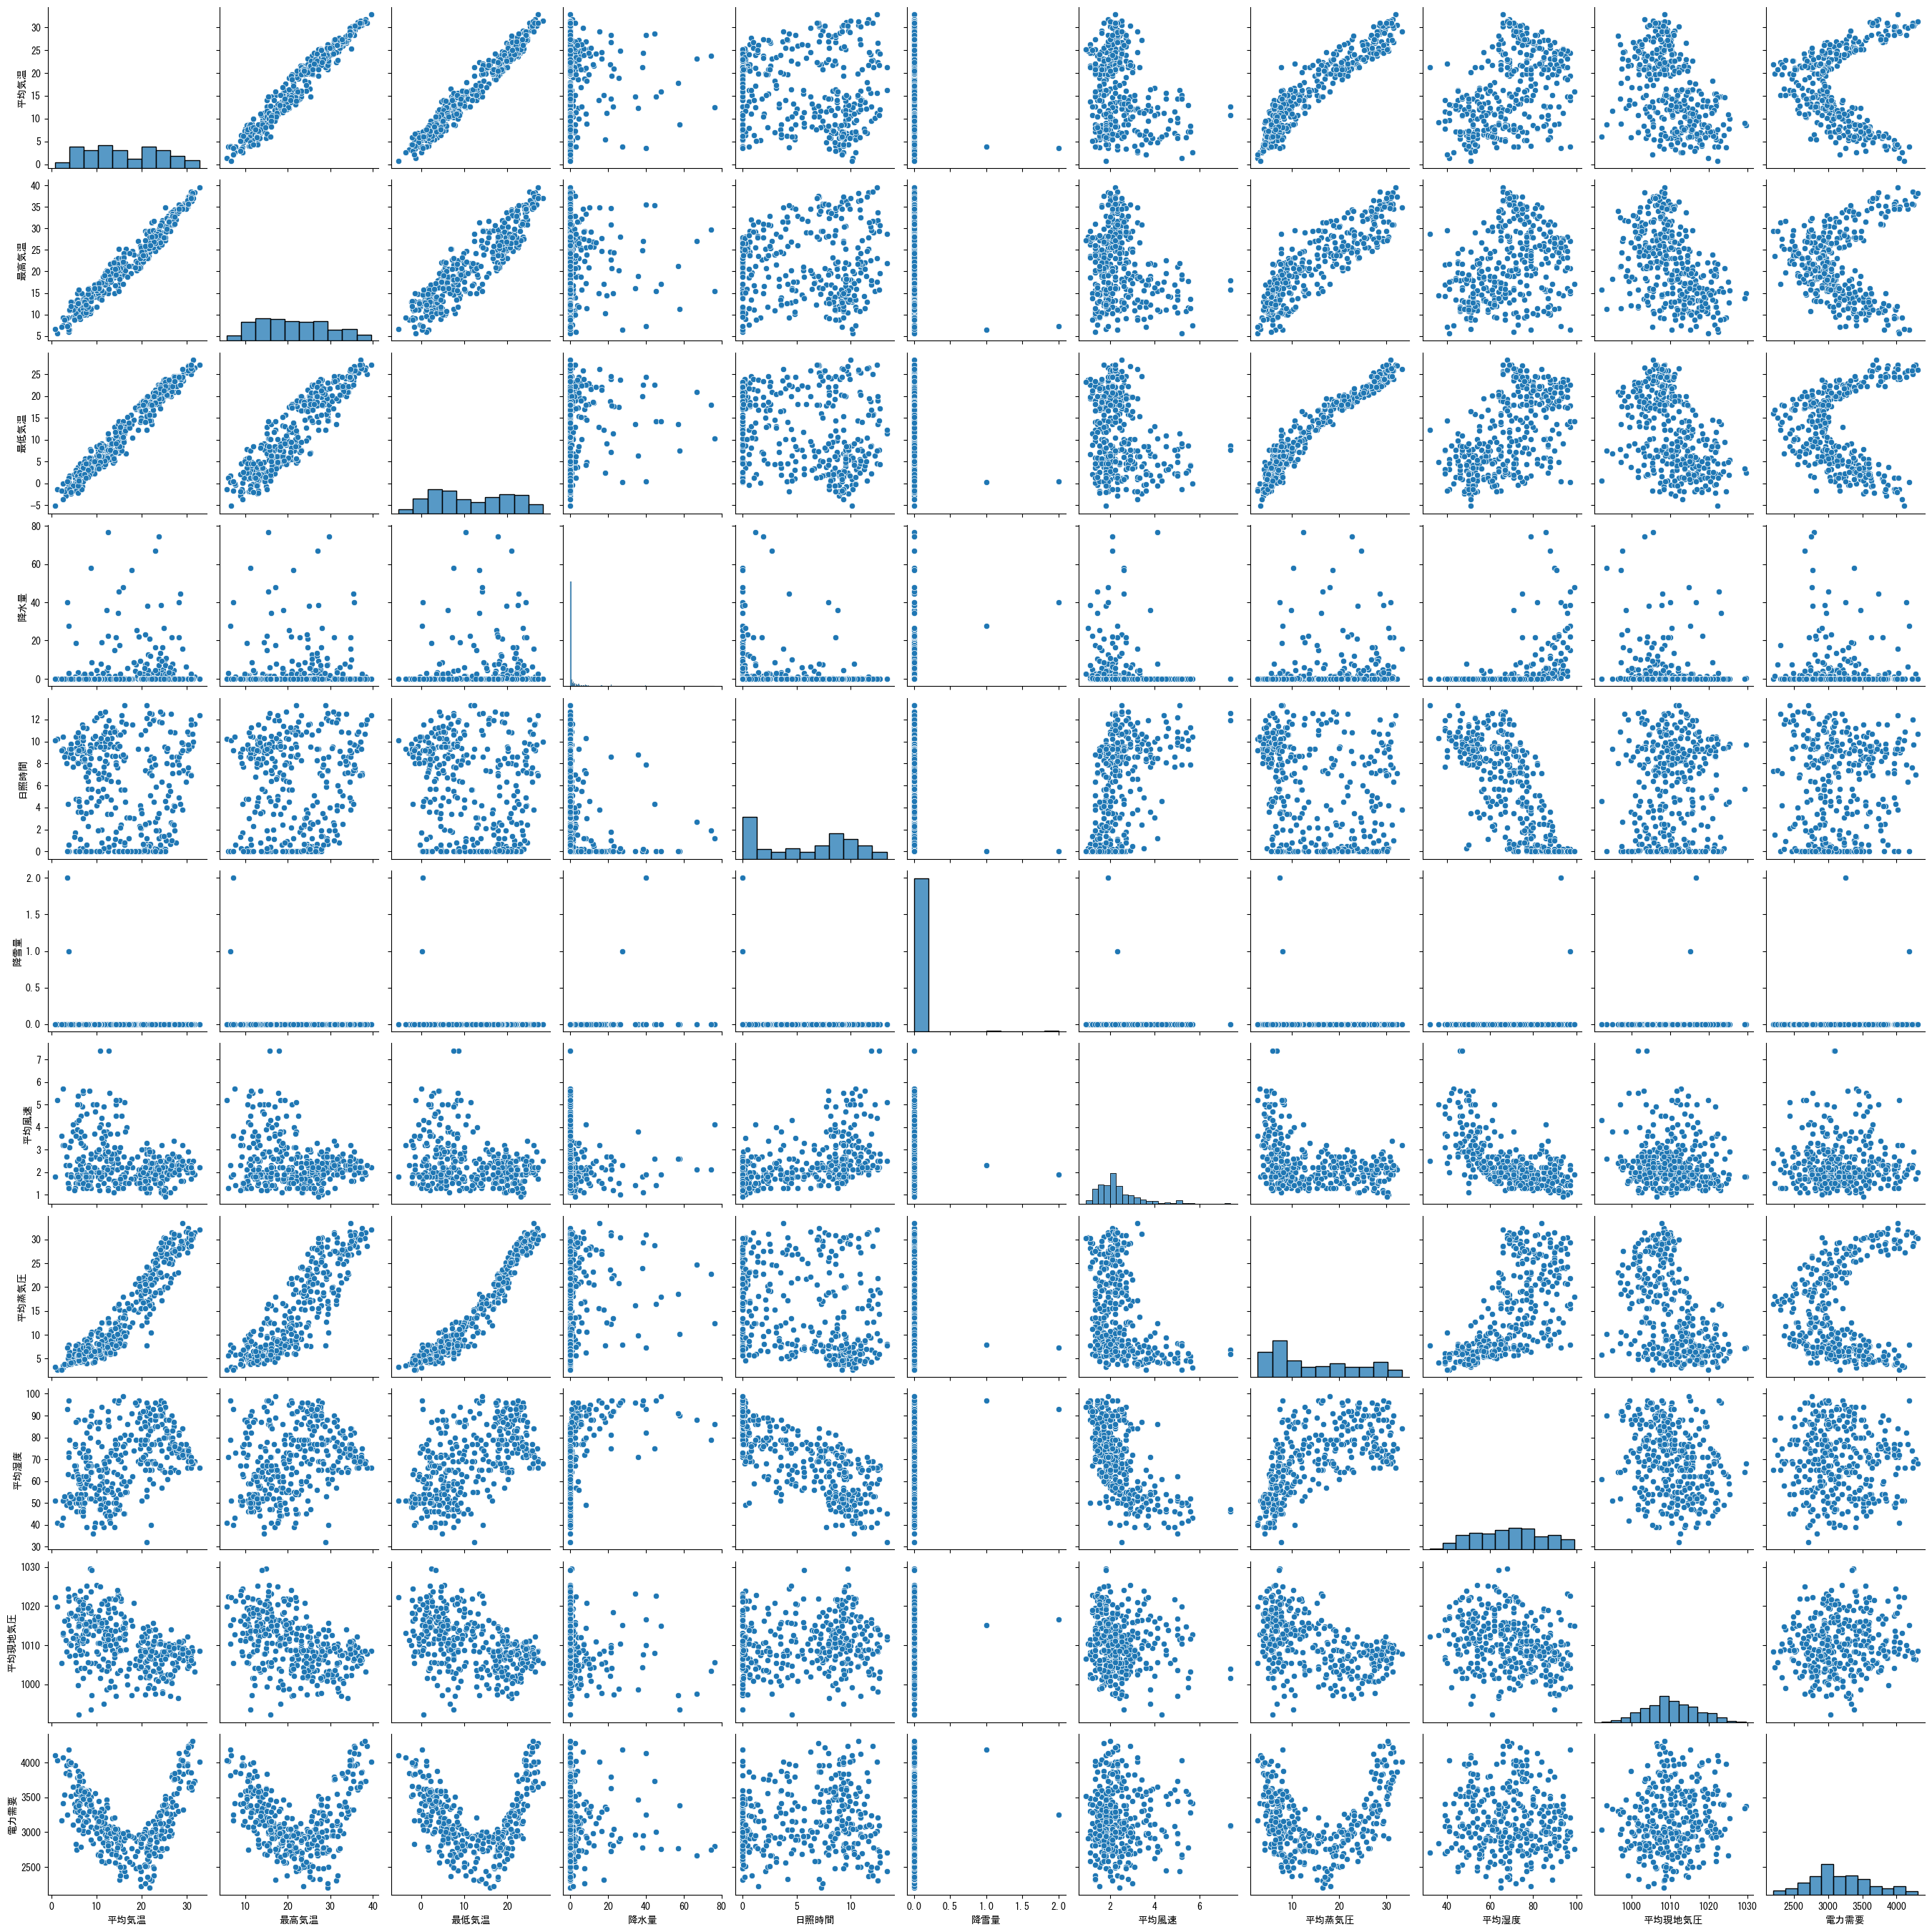

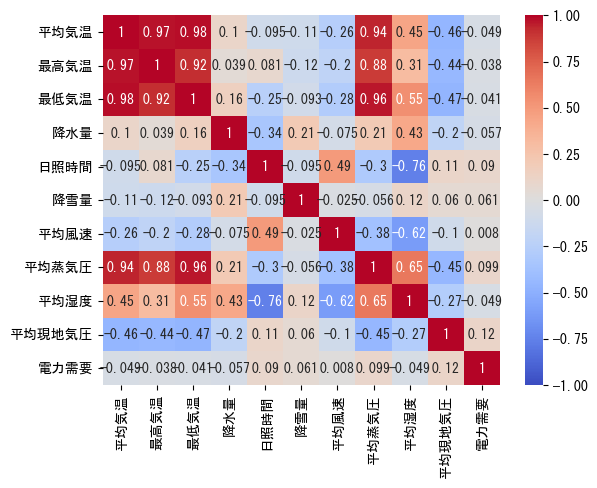

In [3]:
# ペアプロットの描画
all_data = pd.concat([X_weather, Y_power], axis=1)
plt.rcParams['font.family'] = 'MS Gothic'
sns.pairplot(all_data)
plt.show()

# ヒートマップの描画
corr = all_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.show()

　最適モデルのVIFを見ると，平均気温と平均蒸気圧の値が10を超えており，次いで，平均湿度が6程度と大きい．一方で，ペアプロットやヒートマップを見ると，平均気温と平均蒸気圧の間には強い正の相関が見られ，平均湿度と平均蒸気圧の間にはやや強い正の相関が見られる．したがって，この影響によってVIFの値が大きくなっているものと考えられ，平均蒸気圧と平均湿度を除いたモデルを最後に確認する．  
#### (4) 重回帰分析の結果（最適な重回帰モデル）

In [4]:
combi = ['平均気温', '日照時間', '降雪量', '平均風速']
X_optimal, Y_optimal = dataLoading(year, month, combi)
print('##########################################################################################')
print('##########################################################################################')
print('###                                                                                    ###')
print('###   Condition :             Optimal Independent Variables                            ###')
print('###                                                                                    ###')
print('##########################################################################################')
print('##########################################################################################')
multipleRegression(X=X_optimal, Y=Y_optimal, SUMMARY=True, VIF=True)
print('##########################################################################################')
print('##########################################################################################\n')

##########################################################################################
##########################################################################################
###                                                                                    ###
###   Condition :             Optimal Independent Variables                            ###
###                                                                                    ###
##########################################################################################
##########################################################################################
                            OLS Regression Results                            
Dep. Variable:                   電力需要   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.556
Date:                Sun, 09 Jun 2024   Prob (F

,VIF
const,13.937270
平均気温,1.091724
日照時間,1.335817
降雪量,1.023767
平均風速,1.411289


##########################################################################################
##########################################################################################



　AICやBICの値は大きくなってしまっているが，全ての独立変数に対し，従属変数が1次の線形和で表現できると仮定している重回帰では，必ずしも上手く推定できるとは限らない．したがって，今回はこのモデルが限界であるといえる．  
　さらに精度を上げるには，機械学習などの，より多くのパラメータを扱うことのできる手法によって，推定モデルを作成する必要がある．

### 感想  
　重回帰分析で，独立変数を決定すること，すなわち重回帰モデルを決定することは，基本的な機械学習に用いる説明変数の選定をする過程に似ていると感じた．特に，相関の高い変数同士を独立変数（説明変数）として与えるべきではないということに関して，機械学習をしていた際は，相関が高いデータでも説明変数による情報が多い方が厳密な推定モデルが構築される気がすることに矛盾すると感じていた．しかし，今回の学びで，機械学習自体が変数が膨大である場合に，半自動的に重回帰モデルを決定する過程そのものであることに気付いた．そして，重回帰分析および機械学習において，各独立変数（説明変数）が互いに独立で無相関であること前提に分析されるものであるからだと理解した．したがって，相関の高い独立変数同士をモデルに含めると，それらが無相関であるという仮定に矛盾し，モデルの精度を劣化させるということが分かった．  
　また，課題ではなかったが，2元性を持つ事象に対して，ロジスティック回帰を用いることによって，定量的かつ適切に分析をすることができるということを学び，アンケートの結果などを解析する際などに有効であると思った．また，ロジスティック回帰の式は，機械学習の活性化関数で見られるシグモイド関数に似ており，性質の類似などがあると面白いと思った．
　